<a href="https://colab.research.google.com/github/JintaoWang1/ENEL645-Group12/blob/main/ENEL645_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installations and imports

In [ ]:
!pip install yake
!pip install stop-words
import numpy as np
import pandas as pd 
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import yake
from operator import itemgetter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from stop_words import get_stop_words
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

**Loading the data into training and testing dataframes**

In [ ]:
train_df = pd.read_csv("/content/ENEL645/train.csv")
test_df = pd.read_csv("/content/ENEL645/test.csv")

**Dataset exploration**

In [ ]:
display(train_df)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [ ]:
#Checking to see how many NaN values are in the dataset

train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
#Checking for an imbalanced dataset

train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

**Extracting keywords to fill NaN values**

In [ ]:
#Extracting keywords for the training set and test sets

extractor = yake.KeywordExtractor(n=2)

for index, row in train_df.iterrows():
  if pd.isna(row['keyword']):
    keywords = extractor.extract_keywords(row["text"])
    row["keyword"] = max(keywords, key=itemgetter(1))[0]
    train_df.at[index, "keyword"] = row["keyword"]

for index, row in test_df.iterrows():
  if pd.isna(row['keyword']):
    keywords = extractor.extract_keywords(row["text"])
    if not keywords:
      row["keyword"] = "null"
    else:
      row["keyword"] = max(keywords, key=itemgetter(1))[0]
    test_df.at[index, "keyword"] = row["keyword"]

**Data preprocessing**

In [ ]:
#Tokenization

nltk.download('punkt')
train_tokens = train_df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
test_tokens = test_df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#Stop word removal. Added additional cases from manual examination of the dataset

nltk.download('stopwords')

eng_stopwords = stopwords.words('english') 
        
stop_en = list(get_stop_words('en'))
stop_en.extend(list(stopwords.words('english')) )
stop_en.extend(['.',',','', 'i i','?','\'\'',"''",'y','S','@','*','out','==','df','e.g.','\'m','\[',"'m",':', ')', '(','n\'t', '\'','``','``','\'s', 
                'https://','-', "#", "^", "§", "║", "«", "╔", "!", "...", "//t", "//", "http", "Ã", "·", "´", "[", "]", "=", "&", ">", "<", "http://t.co/", "//t.co","Â‰Ã"])
train_stopwords=train_tokens.apply(lambda words: [word for word in words if word not in stop_en])
test_stopwords=test_tokens.apply(lambda words: [word for word in words if word not in stop_en])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Stemming

ps=PorterStemmer()
train_stemming=train_stopwords.apply(lambda x: [ps.stem(word) for word in x])
test_stemming=test_stopwords.apply(lambda x: [ps.stem(word) for word in x])

In [ ]:
#Saving the preprocessed text back to the dataframe

train_df['text'] = train_stemming
test_df['text'] = test_stemming

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,earthquake,NaN,"[our, deed, reason, earthquak, may, allah, for...",1
1,4,fire,NaN,"[forest, fire, near, La, rong, sask, canada]",1
2,5,evacuation,NaN,"[all, resid, ask, 'shelter, place, notifi, off...",1
3,6,evacuation,NaN,"[13,000, peopl, receiv, wildfir, evacu, order,...",1
4,7,photo,NaN,"[just, got, sent, photo, rubi, alaska, smoke, ...",1


**Feature extraction**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

text_vectorizer = TfidfVectorizer()
keyword_vectorizer = TfidfVectorizer()

In [ ]:
#Vectorizing the text using Tfidf

joined_train = train_df['text'].apply(' '.join)
keyword_train_vectors = keyword_vectorizer.fit_transform(train_df.keyword)
text_train_vectors = text_vectorizer.fit_transform(joined_train)

joined_test = test_df['text'].apply(' '.join)
keyword_test_vectors = keyword_vectorizer.transform(test_df.keyword)
text_test_vectors = text_vectorizer.transform(joined_test)

In [ ]:
#Creating the feature matrix and splitting into training and validation data

from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(hstack([keyword_train_vectors, text_train_vectors]), train_df["target"], random_state=12)
X_test = hstack([keyword_test_vectors, text_test_vectors])

**Testing base models**

In [ ]:
from sklearn.model_selection import cross_validate

def get_classifier_cv_score(model, X, y, scoring, cv):
  scores = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)
    
  mean_train_score = scores["train_score"].mean()
  mean_val_score = scores["test_score"].mean()
    
  return mean_train_score, mean_val_score

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

scores_tup = []

model_list=[RidgeClassifier(), LogisticRegression(), BernoulliNB(), MultinomialNB(), SGDClassifier(random_state=12), LinearSVC(), MLPClassifier(hidden_layer_sizes=(10,), max_iter = 200)]

for models in model_list:
    
            training_score, validation_score = get_classifier_cv_score(models, X_train, Y_train, scoring='f1', cv=10);
     
            scores_tup.append([models, training_score, validation_score]);

            scores_tup=sorted(scores_tup, key = lambda x: x[2], reverse =True )

print("Sorted Average Results Based on Validation Score:\n")

for scores in scores_tup:
                
        print(scores[0], ": training score  = {:.3f}".format(scores[1]))
        print(scores[0], ": validation score = {:.3f}".format(scores[2]))
        print("\n")

Sorted Average Results Based on Validation Score:

BernoulliNB() : training score  = 0.879
BernoulliNB() : validation score = 0.752


LinearSVC() : training score  = 0.985
LinearSVC() : validation score = 0.748


RidgeClassifier() : training score  = 0.962
RidgeClassifier() : validation score = 0.747


SGDClassifier(random_state=12) : training score  = 0.967
SGDClassifier(random_state=12) : validation score = 0.747


LogisticRegression() : training score  = 0.862
LogisticRegression() : validation score = 0.739


MultinomialNB() : training score  = 0.842
MultinomialNB() : validation score = 0.739


MLPClassifier(hidden_layer_sizes=(10,)) : training score  = 0.997
MLPClassifier(hidden_layer_sizes=(10,)) : validation score = 0.725




**Optimizing the top three models using grid search**

In [ ]:
from sklearn.model_selection import GridSearchCV
#Optimization of BernoulliNB

bnb_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

bnb_grid = GridSearchCV(BernoulliNB(), bnb_params, scoring='f1', cv=10, verbose=1)
bnb_grid.fit(X_train, Y_train)

print(bnb_grid.best_params_)
print(bnb_grid.best_score_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
{'alpha': 0.1}
0.7658112152963166


In [ ]:
#Optimization of RidgeClassifier

ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10],
                'fit_intercept': [True, False]}

ridge_grid = GridSearchCV(RidgeClassifier(), ridge_params, scoring='f1', cv=10, verbose=1)
ridge_grid.fit(X_train, Y_train)

print(ridge_grid.best_params_)
print(ridge_grid.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'alpha': 1, 'fit_intercept': False}
0.7497336610459008


In [ ]:
#Optimization of LinearSVC

lsvc_params = {'C': [0.001, 0.01, 0.1, 1, 10],
               'loss': ['hinge', 'squared_hinge'],
               'fit_intercept': [True, False],
               'max_iter': [4000]}

lsvc_grid = GridSearchCV(LinearSVC(), lsvc_params, scoring='f1', cv=10, verbose=1)
lsvc_grid.fit(X_train, Y_train)

print(lsvc_grid.best_params_)
print(lsvc_grid.best_score_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
{'C': 1, 'fit_intercept': False, 'loss': 'hinge', 'max_iter': 4000}
0.7518336541954891


**Retraining of the best model with optimized parameters**

In [ ]:
# Retrain BernoulliNB with optimized hyperparameters

best_model = BernoulliNB(alpha=0.1)

best_model.fit(X_train, Y_train)
Y_pred = best_model.predict(X_val)

**Viewing the results of the prediction on the validation set**

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Y_val, Y_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1109
           1       0.77      0.71      0.74       795

    accuracy                           0.79      1904
   macro avg       0.79      0.78      0.78      1904
weighted avg       0.79      0.79      0.79      1904



In [ ]:
def plot_confusion_mat(y_actual, y_pred, labels, title=''):
  mat = confusion_matrix(y_actual, y_pred)

  sns.heatmap(mat, square=True, cmap="viridis", annot=True, xticklabels = labels, yticklabels = labels, fmt='g')
  plt.xlabel('predicted value')
  plt.ylabel('true value');
  plt.title(title);

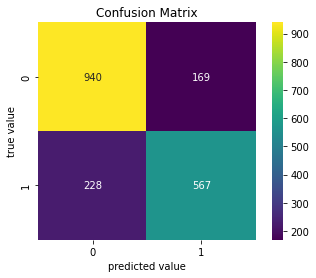

In [ ]:
plot_confusion_mat(Y_val, Y_pred,[0,1],'Confusion Matrix');

**Creating the submission file for the Kaggle competition**

In [ ]:
submission = pd.read_csv("/content/ENEL645/sample_submission.csv")
submission["target"] = best_model.predict(X_test)
submission.head()

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1


In [ ]:
submission.to_csv("submission.csv", index=False)